In [1]:
import keras
from keras_self_attention import SeqSelfAttention

Using TensorFlow backend.


In [2]:
!pip install nltk
from nltk.translate.bleu_score import sentence_bleu

In [3]:
!pip install rouge
from rouge import Rouge

In [4]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [5]:
data=pd.read_csv("C:/Users/Ruba/Downloads/Reviews.csv",nrows=100000)

In [6]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   abstract                88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ruba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stop_words = set(stopwords.words('english'))

In [11]:
from nltk.tokenize import sent_tokenize, word_tokenize
#from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
#porter=PorterStemmer()
sb_stem =SnowballStemmer("english")
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(sb_stem.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)



In [12]:

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [13]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [14]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [15]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [16]:
#call the function
cleaned_abstract = []
for t in data['abstract']:
    cleaned_abstract.append(text_cleaner(t,1))

In [17]:
cleaned_abstract[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [18]:
#restore values of text / abstract after cleaning process 
data['cleaned_text']=cleaned_text
data['cleaned_abstract']=cleaned_abstract

In [19]:
#remove empty spaces and NA ones
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

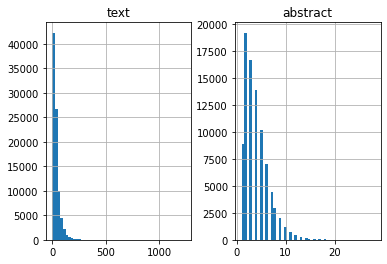

In [20]:

# find the length of sentences in each TEXT / Summay to know the MIN.MAX ranges length
import matplotlib.pyplot as plt

text_word_count = []
abstract_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_abstract']:
      abstract_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'abstract':abstract_word_count})

length_df.hist(bins = 50)
plt.show()

In [21]:
# limit the length of MAX 
max_text_len=30
max_abstract_len=8

In [22]:
# remove the shorter ones than the MAX (max_text_len) limite above
cleaned_text =np.array(data['cleaned_text'])
cleaned_abstract=np.array(data['cleaned_abstract'])

short_text=[]
short_abstract=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_abstract[i].split())<=max_abstract_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_abstract.append(cleaned_abstract[i])
        
df=pd.DataFrame({'text':short_text,'abstract':short_abstract})

In [23]:
# add START and END special tokens (StartTok EndToken)
df['abstract'] = df['abstract'].apply(lambda x : 'sostok '+ x + ' eostok')

In [24]:
# splitting the data 90/10 using train_test_split function
from sklearn.model_selection import train_test_split
x_train,x_validate,y_train,y_validate=train_test_split(np.array(df['text']),np.array(df['abstract']),test_size=0.2,random_state=0,shuffle=True)

In [25]:
#EPU_train, EPU_test = train_test_split(np.array(df['text']),np.array(df['abstract']),test_size=0.2)

In [26]:
#Text Tokenizer 

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on x_train data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

In [27]:

# find the least used words by count limit here is 4times
threshold=4 

count=0
tot_count=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_count=tot_count+1
    tot_freq=tot_freq+value
    if(value<threshold):
        count=count+1
        freq=freq+value
    
print("Number of rare words in vocabulary:",(count/tot_count))
print("Total Coverage of rare words:",(freq/tot_freq))

Number of rare words in vocabulary: 0.6600245898164243
Total Coverage of rare words: 0.031248176630529916


In [28]:
x_tokenizer = Tokenizer(num_words=tot_count-count) 

In [29]:
print(tot_count-count)

8019


In [30]:
#prepare a tokenizer for reviews on training data
words_count=tot_count-count #6716
x_tokenizer = Tokenizer(num_words=6716) 
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences texts_to_sequences
x_train_seq    =   x_tokenizer.texts_to_sequences(x_train) 
x_validate_seq   =   x_tokenizer.texts_to_sequences(x_validate)

#post padding  zero upto maximum length to unify the sentences lengths   
x_train    =   pad_sequences(x_train_seq,  maxlen=max_text_len, padding='post')
x_validate   =   pad_sequences(x_validate_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_vocabulary   =  x_tokenizer.num_words + 1

In [31]:
x_vocabulary

6717

In [32]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

In [33]:
threshold=6

count=0
tot_count=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_count=tot_count+1
    tot_freq=tot_freq+value
    if(value<threshold):
        count=count+1
        freq=freq+value
    
print("number of rare words in vocabulary:",(count/tot_count))
print("Total Coverage of rare words:",(freq/tot_freq))

number of rare words in vocabulary: 0.786850969915205
Total Coverage of rare words: 0.05761720726007163


In [34]:
words_count=tot_count-count
print(words_count)

1835


In [35]:
#prepare a tokenizer for reviews on training data

words_count=tot_count-count
y_tokenizer = Tokenizer(num_words=words_count) 
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences using texts_to_sequences
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_validate_seq   =   y_tokenizer.texts_to_sequences(y_validate) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_abstract_len, padding='post')
y_validate   =   pad_sequences(y_validate_seq, maxlen=max_abstract_len, padding='post')

#size of vocabulary
y_vocabulary  =   y_tokenizer.num_words +1

In [36]:
y_tokenizer.word_counts['sostok'],len(y_train) # those must be equal

(37744, 37744)

In [37]:
from keras import backend as K
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [38]:
import tensorflow as tf
#K.clear_session()
tf.keras.backend.clear_session()

In [39]:
ind=[]
for i in range(len(y_validate)):
    cnt=0
    for j in y_validate[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_validate=np.delete(y_validate,ind, axis=0)
x_validate=np.delete(x_validate,ind, axis=0)

In [40]:
from tensorflow.keras.layers import Attention
from attention import AttentionLayer

In [41]:
from attention import AttentionLayer

In [42]:
from keras import backend as K 
#K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_vocabulary, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_vocabulary, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_vocabulary, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      671700      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [43]:
tf.keras.layers.Attention

tensorflow.python.keras.layers.dense_attention.Attention

In [44]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [45]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
es = EarlyStopping(patience=1, monitor='val_loss', restore_best_weights=True) #accuracy, loss, val_loss, val_accuracy

In [46]:
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,
                  epochs=16,callbacks=[es],batch_size=128, 
                  validation_data=([x_validate,y_validate[:,:-1]], y_validate.reshape(y_validate.shape[0],y_validate.shape[1], 1)[:,1:]))
model.save('encoder_decoder_17.h5')

Epoch 1/16
295/295 [==============================] - 532s 2s/step - loss: 3.3619 - val_loss: 2.5959
Epoch 2/16
295/295 [==============================] - 556s 2s/step - loss: 2.5374 - val_loss: 2.4800
Epoch 3/16
295/295 [==============================] - 541s 2s/step - loss: 2.3948 - val_loss: 2.3945
Epoch 4/16
295/295 [==============================] - 556s 2s/step - loss: 2.3135 - val_loss: 2.3341
Epoch 5/16
295/295 [==============================] - 514s 2s/step - loss: 2.2388 - val_loss: 2.2789
Epoch 6/16
295/295 [==============================] - 515s 2s/step - loss: 2.1708 - val_loss: 2.1935
Epoch 7/16
295/295 [==============================] - 522s 2s/step - loss: 2.0669 - val_loss: 2.1413
Epoch 8/16
295/295 [==============================] - 523s 2s/step - loss: 1.9984 - val_loss: 2.1096
Epoch 9/16
295/295 [==============================] - 524s 2s/step - loss: 1.9262 - val_loss: 2.0816
Epoch 10/16
295/295 [==============================] - 527s 2s/step - loss: 1.8517 - val_lo

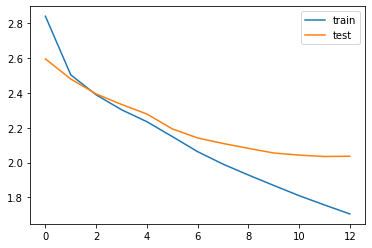

In [47]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [48]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [49]:
### inference layer
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [50]:
#@ prediction Phase

In [51]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_abstract_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [52]:
def seq2abstract(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [53]:
for i in range(0,2):
    print("Review:",seq2text(x_train[i]))
    print("Original abstract:",seq2abstract(y_train[i]))
    print("Predicted abstract:",decode_sequence(x_train[i].reshape(1,max_text_len)))
    print("\n")

Review: fog chaser great bold body taste unlike brands leave harsh taste great product recommend 
Original abstract: great taste 
Predicted abstract:  great coffee


Review: fish great fresh sea black years like remembered thank reminds home ordering fish 
Original abstract: great fish 
Predicted abstract:  great taste




In [54]:
for i in range(0,2):
    print("Review:",seq2text(x_validate[i]))
    print("Original summary:",seq2abstract(y_validate[i]))
    print("Predicted summary:",decode_sequence(x_validate[i].reshape(1,max_text_len)))
    print("\n")

Review: simply bar simply fantastic love vegan high protein helpful need find alternative protein sources also provide amazing flavors favorite peanut butter one 
Original summary: simply awesome 
Predicted summary:  delicious


Review: longer find flavored tea stores amazon place get thanks amazon 
Original summary: raspberry tea 
Predicted summary:  great tea




In [55]:
EPU_seq = data[['abstract', 'Text']]

In [58]:
len(EPU_seq)

88354

In [59]:
EPU_train, EPU_test = train_test_split(EPU_seq, test_size=.10)

In [60]:
print(EPU_train.shape)
print(EPU_test.shape)

(79518, 2)
(8836, 2)


In [62]:
x_train_seq[0]

[1747, 1940, 1, 316, 770, 6, 807, 212, 691, 2217, 6, 1, 5, 38]

In [65]:
EPU_train['abstract']

66852                                              Extremely Good
57579                                                 Over Priced
58849                                                  Yam treats
21264                                               Teenie Weenie
93068    Yum... using leftover cooked roast chicken in the fridge
                                   ...                           
26595                                          What a great idea!
33029                                 I like it but my kids don't
39126                                                        bpa?
40041                                  Thought I was going to die
63721                                       It Just Wasn't For Me
Name: abstract, Length: 79518, dtype: object

In [70]:
EPU_train['Text'][:37744].shape

(37744,)

In [69]:
x_train.shape

(37744, 30)

In [ ]:
#max_text_len=30
#max_abstract_len=8

In [72]:
EPU_train['Text'][:37744] = [decode_sequence(sequence.reshape(1, max_text_len)) for sequence in x_train]

EPU_train.to_csv('EPU complete_train_full01.csv')

In [73]:
x_validate.shape

(9158, 30)

In [74]:
EPU_train['Text'].shape

(79518,)

In [76]:
EPU_test['Text'].shape

(8836,)

In [77]:
#change the shape to match here 
EPU_test['Text'][:8836] = [decode_sequence(sequence.reshape(1, max_text_len)) for sequence in x_validate[:8836]]
EPU_test.to_csv('EPU complete_test_full01.csv')

In [81]:
#save them and read to array 
EPU_train_full = pd.read_csv('EPU complete_train_full01.csv')
EPU_test_full = pd.read_csv('EPU complete_test_full01.csv')

In [105]:
test_df = pd.DataFrame()
test_df02 = pd.DataFrame()

In [126]:
sequences = [seq2text(x_validate[i]) for i in range(len(x_validate))]
headlines = [seq2abstract(y_validate[i]) for i in range(len(y_validate))]

In [127]:
#y_validate --test_sequences_headline
#x_validate--test_sequences_article

In [128]:
test_df['Text'] = sequences
test_df['abstract'] = headlines


In [132]:
y_validate

array([[   1,  247,   40, ...,    0,    0,    0],
       [   1,  547,   14, ...,    0,    0,    0],
       [   1,   16,    2, ...,    0,    0,    0],
       ...,
       [   1,    3,   52, ...,    0,    0,    0],
       [   1,    9,   17, ...,    0,    0,    0],
       [   1, 1619,   91, ...,    0,    0,    0]])

In [129]:
EPU_test_full['Text']

3        my dog loves this food
41                great product
42                  great taste
45                 great coffee
53                  great taste
                 ...           
8811              great popcorn
8815              great product
8820              great product
8830                 good stuff
8835                great taste
Name: Text, Length: 842, dtype: object

In [133]:
test_df['Headline_Gen'] = EPU_test_full['Text'] #test_df02['Text'] = test_df['Headline_Gen']

In [134]:
test_df['Headline_Gen']

0                           NaN
1                           NaN
2                           NaN
3        my dog loves this food
4                           NaN
                 ...           
9153                        NaN
9154                        NaN
9155                        NaN
9156                        NaN
9157                        NaN
Name: Headline_Gen, Length: 9158, dtype: object

In [135]:
sequences = [seq2text(x_train[i]) for i in range(len(x_train))]
headlines = [seq2abstract(y_train[i]) for i in range(len(y_train))]

In [136]:
train_df = pd.DataFrame()
train_df02 = pd.DataFrame()

In [137]:
train_df['Text'] = sequences
train_df['abstract'] = headlines
train_df['Headline_Gen'] = EPU_train_full['Text'] 

In [138]:
EPU_test_full_clean = test_df
EPU_train_full_clean = train_df

In [139]:
EPU_test_full_clean.to_csv('EPU complete_test_full01.csv')
EPU_train_full_clean.to_csv('EPU complete_train_full01.csv')

In [144]:
labels_train = EPU_train[['abstract']]
#labels_test = EPU_test[['abstract']]

In [145]:
EPU_train_full = pd.merge(EPU_train_full, labels_train, left_index=True, right_index=True)
EPU_test_full = pd.merge(EPU_test_full, labels_test, left_index=True, right_index=True)

In [146]:
EPU_test_full

,Unnamed: 0,abstract_x,Text,abstract_y,ROUGE,abstract_x,abstract_y,abstract
3,90487,Epic Coffee!!,my dog loves this food,Cough Medicine,1.0,Cough Medicine,Cough Medicine,Cough Medicine
41,47052,Natural Balance Reduced Calorie Formula,great product,Oatmeal For Oatmeal Lovers,1.0,Oatmeal For Oatmeal Lovers,Oatmeal For Oatmeal Lovers,Oatmeal For Oatmeal Lovers
42,68434,RICE,great taste,Food-Great,1.0,Food-Great,Food-Great,Food-Great
45,27176,"Hey, thatsa spiceea Beef SticK!",great coffee,Hearty Oatmeal,1.0,Hearty Oatmeal,Hearty Oatmeal,Hearty Oatmeal
53,27083,I lurve me some La Crotch water,great taste,not ass kickin,1.0,not ass kickin,not ass kickin,not ass kickin
...,...,...,...,...,...,...,...,...
8811,48524,Amazingly Delicious!,great popcorn,Low-cost Latte,1.0,Low-cost Latte,Low-cost Latte,Low-cost Latte
8815,67159,Good deal with caveats,great product,"Versatile ""must-have"" for your pantry",1.0,"Versatile ""must-have"" for your pantry","Versatile ""must-have"" for your pantry","Versatile ""must-have"" for your pantry"
8820,78803,Adult w/GERD,great product,Great product!,1.0,Great product!,Great product!,Great product!
8830,89179,Organic Coconut Oil Great to cook with,good stuff,Starbucks be gone!,1.0,Starbucks be gone!,Starbucks be gone!,Starbucks be gone!


In [ ]:
EPU_test_full

In [147]:
EPU_test_full.to_csv('EPU_complete_train_full_FIXED_W_SCORES.csv')

In [154]:
rouge = Rouge()
def rouge_scoring(row):
    reference = str(row['Text'])
    candidate = str(row['abstract'])
    score = rouge.get_scores(candidate, reference)[0]['rouge-1']['r']

    return score

In [155]:

EPU_train_full['ROUGE'] = EPU_train_full.apply(lambda row: rouge_scoring(row), axis=1)
#EPU_test_full['ROUGE'] = EPU_test_full.apply(lambda row: rouge_scoring(row), axis=1)

In [156]:
def bleu_scoring(row):

    reference = row['Text']
    candidate = row['abstract']

    reference = [str(reference).split()]
    candidate = str(candidate).split()
    score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))

    return score

In [158]:
EPU_train_full['BLEU'] = EPU_train_full.apply(lambda row: bleu_scoring(row), axis=1)
EPU_test_full['BLEU'] = EPU_test_full.apply(lambda row: bleu_scoring(row), axis=1)

In [163]:
def get_first_20(row):

    first_20 = ' '.join([word for i, word in enumerate(row['abstract'].split()) if i <=20])
    return first_20

In [164]:
EPU_test_full['Bench_Seed'] = EPU_test_full.apply(lambda row: get_first_20(row), axis=1)

In [165]:
EPU_test_full['Baseline_ROUGE'] = EPU_test_full.apply(lambda row: rouge_scoring(row), axis=1)
EPU_test_full['Baseline_BLEU'] = EPU_test_full.apply(lambda row: bleu_scoring(row), axis=1)

In [166]:
EPU_test_full.to_csv('EPU_complete_train_full_FIXED_W_SCORES02.csv')

In [61]:
len(x_train)

37744

In [78]:
df['abstract'].shape


(47181,)

In [79]:
x_train.shape

(37744, 30)

In [81]:
x_validate.shape

(9158, 30)

In [80]:
y_train[:,:-1].shape

(37744, 7)

In [76]:
df['text'].shape

(47181,)

In [65]:
EPU_train, EPU_test = train_test_split(EPU_seq, test_size=.20)
#df['text'] = x_train[1]
#EPU_train=['']
#EPU_train['Headline'] =df['text'] 


In [ ]:
#train_sequences_article ----> x_train
#train_sequences_headline  ----> y_train[:,:-1]
#train_sequences_headline ----> y_train
#train_sequences_headline ----> y_train

In [ ]:
EPU_train['Text']

In [118]:
EPU_train['Text']

62514                                                  I have tried many different decaff coffees and 90% of the times they just don't cut it.  But this one was really good, great way to relax in the evening.
10301    My day had been nothing exceptional.  I had forgotten to take lunch and the afternoon was dragging.  Upon returning to my desk I saw a bag of these on my desk that had been here for a few days; a ...
46716    These 'treats' are the perfect disguise to hide daily meds for my little furballs.  Plus, since they cost about $10 a bag at the store, this price and low shipping fee is a bargain!  Thanks  a bun...
61179    I admit that while the structure of this cookie seems familiar, I'm not particularly acquainted with "Mallomars". Now, to start with, I'm a cookie lover, a marshmallow lover, and a chocolate lover...
32500    I love this Crystal Light ICED TEA PEACH but can no longer find it in my grocery stores. So the other day I ordered it online and maybe because they were o

In [66]:
EPU_test['Text']

12545    I agree this is not extremely cheesy, but that is what I like about it.  I have been using this for years and only one store near me carried it.  I have recently moved to Florida and can't find it...
37023    My grandson is thriving on this formula he was having a lot of difficulty with regular formula and this sensitive one does the trick he has gained inches and pounds and is happy and laughing we th...
21859    Jack, our 3 year old LabraDoodle (I refer to him as a "LabraDingo" sometimes because he's so nutsy) really enjoyed this Jug -- our second one lasted 7 months of heavy use before the rubberized rop...
16591    This Switch Kiwi Berry drink comes is as great, easy to handle, streamlined candy.  However, it does delivery an intense, fruit, flavor.  Great when you really need a sweet fruit recovery from a h...
25701    Having tried just about every other vegan jerky item on the market I was excited to find one that is completely gluten-based, offering a very reasonable pr

In [116]:
EPU_test['abstract']

41243                      I wish they'd omit the veggies
10350                                           MSG Alert
32641                         Taste's Good & Good For You
82572                                        Great recipe
80908                       I've eaten these for 15 years
                               ...                       
96798                     Not crazy about the packaging..
82521                   Great Mild-medium flavored coffee
35146               Brought back memories of sunny Spain1
30495    Good choice for senior cats who tend to throw up
37353                              This is a favorite tea
Name: abstract, Length: 17671, dtype: object

In [67]:
EPU_train['abstract']

57906                          Hard to stop at just a few
15089                                      Baby Food Cake
89735                             Both of my dogs love it
28880                                   Broken to Bits...
78804                  Good stuff; questionable packaging
                               ...                       
21279                                They are the best...
2058     Does wonders for one's popularity in the kitchen
10467                                                  OK
32118                                             Painful
13226                                  Customer for life!
Name: abstract, Length: 70683, dtype: object